#### Sociology 128D: Mining Culture Through Text Data: Introduction to Social Data Science

# Notebook 4:  Visualizing Sentiment and More using the Empath Library

## Sentiment Analysis and Dictionary Methods using `Empath`

Dictionary methods are among the most straightforward of methods for computational text analysis. A "dictionary" or "lexicon" in this sense is a list of words that we have decided in advance are related to a given topic, or "lexical category," like positive sentiment. To use these dictionaries, we count the words in a given document that are in that dictionary, often taking into account that longer documents aren't necessarily more positive or negative in a meaningful way by virtue of having more words. If we have a list of positive words and a list of negative words, and more words from the first list are in a document, we might say the document is positive. (Sentiment analysis is not restricted to dictionary methods, but that's where we'll start.)

In this notebook, we will learn to use dictionary methods for sentiment analysis and for more general exploration of topics in social media posts using `pandas`, `seaborn`, and Python's [`Empath` library](https://github.com/Ejhfast/empath-client). You can read more about this library in the original paper [here](https://hci.stanford.edu/publications/2016/ethan/empath-chi-2016.pdf). Researchers commonly use paid sets of dictionaries like those available from [LIWC](https://liwc.wpengine.com/), which we saw in the [Paxton et al. (2020)](https://journals.sagepub.com/doi/full/10.1177/0003122420960104) reading for this week. However, the original paper behind `Empath` suggests that similar categories are correlated with LIWC. `Empath` offers 194 lexical categories in total--and it's free! Another benefit is the ease of creating custom dictionaries. To do this, you simply provide a set of seed words, and `Empath` will identify similar words to fill out the dictionary for you. (We'll talk more about how that works later.)

<div class="alert alert-info">
We will consider a few ways to use dictionary methods to analyze social processes. To do this, we're going to use a corpus of posts to Reddit's r/jobs message board between January 1 and December 31, 2020. Specifically, we will consider relationships like the following:
<ul>
    <li>how and when people interact with social media (time of day, day of week)</li>
    <li>how time relates to content and engagement (e.g., the number of replies or upvotes)
    <li>the relationship between content and engagement</li>
    <li>relationships among different types of content (specifically, lexical categories, including sentiment)</li>
</ul>
</div>

More generally, we will consider how these relate to **social processes** and **social institutions**. For example, do users submit content to r/jobs less frequently during standard working hours, or perhaps take the weekends off from posting?

The standard work day and standard work week exert considerable influence on the organization of social life. It makes sense that people working a standard schedule might feel a bit buoyed on the weekend. But what about people who work different hours, or who aren't working? [Young and Lim (2014)](https://sociologicalscience.com/time-network-good/) find that both working and unemployed individuals experience similar changes in subjective wellbeing throughout the course of the week. Both groups report greater wellbeing on weekends. Young and Lim argue that how people experience the rhythm of the week depends on the availability of other people as much as it does on just having time to do things (roughly speaking). That extends to the opportunities that exist based on formal and informal sanctions. Think about how opportunties are shaped by the day of the week. Places of business are often open later on weekends, for example. Now consider how our time-based expectations become entrenced and moralized. People who do shift work often get judged for having a drink after work when "after work" is early in the morning.

We might also use these data to ask questions like whether users writing about a certain topic also tend to write about another topic or set of topics, and we can come up with hypotheses for why we might observe certain associations.

First, we will import the libraries we need for the analyses we'll run.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin
import re
import seaborn as sns
import spacy
import time
import warnings

from empath import Empath
from scipy.stats import pearsonr

%matplotlib inline

warnings.filterwarnings("ignore") # comment out this line to see warnings

sns.set_theme(style="darkgrid")

# python -m spacy download en_core_web_sm

In [2]:
def quick_r(x: str, y: str, df: pd.core.frame.DataFrame) -> str:
    """
    Returns (as a str) the Pearson's correlation coefficient
    with the p-value or asterisks for significant correlations
    *p<0.05, **p<0.01, ***p<0.001
    """
    tmp = df[[x, y]].dropna()
    r, pval = pearsonr(tmp[x], tmp[y])
    if pval < 0.001:
        r = f"{r:.2f}***"
    elif pval < 0.01:
        r = f"{r:.2f}**"
    elif pval < 0.05:
        r = f"{r:.2f}*"
    else:
        r = f"{r:.2f} (p = {pval:.2f})"
    return r

Next, we will load the corpus.

[r/jobs](https://old.reddit.com/r/jobs/) provides the following description:

<blockquote>We aim to empower job seekers and employees through the promotion of their best interests, advice and encouragement. </blockquote>

#### Where is the corpus from?

I pulled ~150 posts to Reddit's r/jobs community per day from [pushshift.io](https://pushshift.io/)'s API for each day in 2020. Many thanks for the work they do to make data available! I have cleaned this corpus already. It includes 49,872 posts in total. The variables include the submission's score ("karma" or "upvotes"), the number of replies, the title of the submission, the text of the submission, and various markers of time. Specifically, I have included the date ("date") and separate variables for the day of the month (1-31), day of the week (as integers 0-6 and strings "Sunday" to "Monday"), day of the year (0-365, as it was a leap year!), week of the year, and the hour (0-23). Although Reddit allows for relative anonymity through the use of usernames/handles, I have provided an ID field ("author_id") in place of the username of the author.

In [3]:
df = pd.read_json("jobs_2020_clean_with_lex.json")

Let's take a quick look at the data. We'll get to an example post and some analyses of the content, but it's important to first have a sense of what the dataset is like overall.

In [4]:
df.head()

,id,author_id,score,num_comments,title,selftext,text,date,dayofyear,hour,...,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical,posts_that_day
68263,0,114337,1,24,I messed up an application for my dream job,"I found my dream job, its a social impact job ...",I messed up an application for my dream job\n ...,2020-12-15,350,0,...,0.017857,0.0,0.0,0.053571,0.0,0.071429,0.0,0.000000,0.000000,180
58753,1,455681,1,3,"Hiring Managers, how common is it for an inter...",I nearly forgot to send a thank you email afte...,"Hiring Managers, how common is it for an inter...",2020-10-16,290,22,...,0.000000,0.0,0.0,0.111111,0.0,0.111111,0.0,0.000000,0.000000,172
49469,2,711804,1,4,Consulting agency - Sr. Associate role meaning?,Hello!\n\nI recently accepted a position as a ...,Consulting agency - Sr. Associate role meaning...,2020-08-27,240,22,...,0.000000,0.0,0.0,0.034483,0.0,0.000000,0.0,0.000000,0.000000,188
6681,3,971458,1,2,How to get that interview in 2020,"Hello, I'm a professional, and a Certified Res...","How to get that interview in 2020\n Hello, I'm...",2020-02-01,32,15,...,0.000000,0.0,0.0,0.054545,0.0,0.027273,0.0,0.000000,0.009091,181
16847,4,90142,1,2,How to be less nervous when talking on the pho...,Hi everyone!\n\nI landed a great job starting ...,How to be less nervous when talking on the pho...,2020-03-14,74,13,...,0.000000,0.0,0.0,0.044444,0.0,0.000000,0.0,0.066667,0.000000,90


`.shape` provides the number of rows (posts) first, followed by the number of columns (variables)

In [5]:
df.shape

(49872, 212)

In [6]:
print(f"{df.shape[0]:,} rows and {df.shape[1]} columns.")

49,872 rows and 212 columns.


## Sample Posts

In [7]:
sample = df.sample(3)
for _, row in sample.iterrows():
    print(row["text"], "\n\n")

How can I prepare for getting a job while I finish my MSc this summer?
 I am about to recieve an MSc in Intl. Security. This summer ill be righting my dissertation, doing a few make up exams and finishing in september. 

I am already looking at jobs. I have a BA in Intl. relations but have never had a internship, but have done uni abroad a few times and gained skills and other attributes that way. How can I prepare for applying for jobs? Entry level jobs want all of this experience ( some 5+ years ) and I feel intimidated. 


Question about experience - bare CV?
 Hey guys,

I've just finished my degree, yay! Got a nice 2:1, v proud etc etc

Anyway, over past years of my life, I have only had two jobs (both long term) with some extra intermittent experience...most of my experience is before I started uni, so should I include this? E.g. from when I'm 16 as to 23

My CV is currently very bare because I focused on uni so much if I don't focus on my experience before uni

Currently my CV, i

### First, let's examine whether there seem to be general trends over the course of the week in the number of posts, the number of comments on posts, and how well posts do ("karma" or "upvotes").

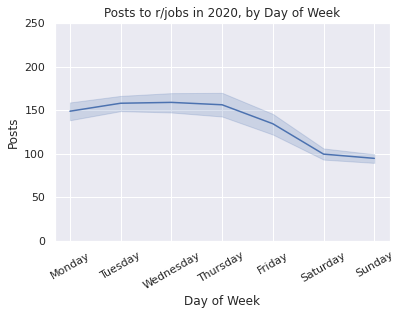

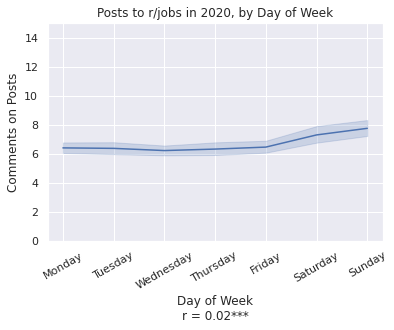

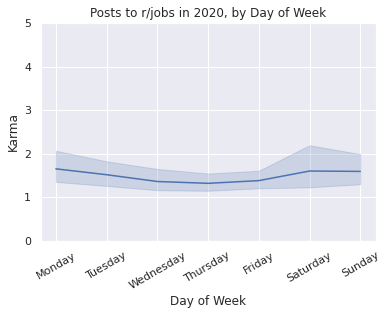

In [8]:
daysofweek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.lineplot(x="dayofweek", y="posts_that_day", ci=95,
             data=df[["dayofweek", "date", "posts_that_day"]].groupby("date").mean())
plt.title("Posts to r/jobs in 2020, by Day of Week")
plt.ylabel("Posts")
plt.ylim(0, 250)
plt.xticks(ticks=range(0,7), labels=daysofweek, rotation=30)
plt.xlabel("Day of Week")
plt.show()

plt.title("Posts to r/jobs in 2020, by Day of Week")
sns.lineplot(x="dayofweek", y="num_comments", data=df, ci=95) # sem
plt.ylabel("Comments on Posts")
plt.ylim(0, 15)
plt.xticks(ticks=range(0,7), labels=daysofweek, rotation=30)
plt.xlabel(f"Day of Week\nr = {quick_r('dayofweek', 'num_comments', df)}")
plt.show()

plt.title("Posts to r/jobs in 2020, by Day of Week")
sns.lineplot(x="dayofweek", y="score", data=df, ci=95) # sem
plt.ylabel("Karma")
plt.ylim(0, 5)
plt.xticks(ticks=range(0,7), labels=daysofweek, rotation=30)
plt.xlabel(f"Day of Week")
plt.show()

### Now let's examine whether there is substantial variation over the course of the day.

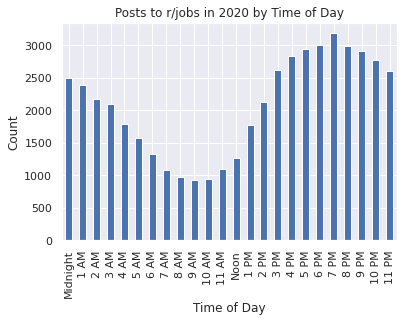

In [9]:
hours = ["Midnight"] + [f"{i} AM" for i in range(1,12)] + ["Noon"] + [f"{i-12} PM" for i in range(13,24)]

df["hour"].value_counts().loc[list(range(24))].plot(kind="bar")
plt.xticks(ticks=list(range(24)), labels=hours)
plt.title("Posts to r/jobs in 2020 by Time of Day")
plt.ylabel("Count")
plt.xlabel("Time of Day")
plt.show()

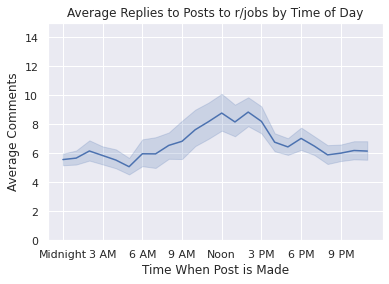

In [10]:
hours = ["Midnight"] + [f"{i} AM" for i in range(1,12)] + ["Noon"] + [f"{i-12} PM" for i in range(13,24)]

sns.lineplot(x="hour", y="num_comments", data=df, ci=95)
plt.title("Average Replies to Posts to r/jobs by Time of Day")
plt.xticks(ticks=range(0,24,3), labels=hours[::3])
plt.xlabel("Time When Post is Made")
plt.ylabel(f"Average Comments")
plt.ylim(0, 15)
plt.show()

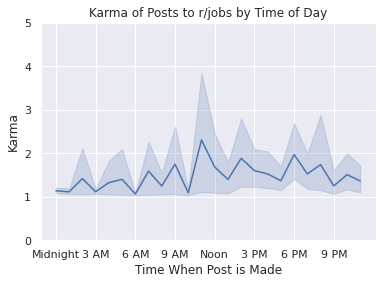

In [11]:
hours = ["Midnight"] + [f"{i} AM" for i in range(1,12)] + ["Noon"] + [f"{i-12} PM" for i in range(13,24)]

sns.lineplot(x="hour", y="score", data=df)
plt.title("Karma of Posts to r/jobs by Time of Day")
plt.xticks(ticks=range(0,24,3), labels=hours[::3])
plt.xlabel("Time When Post is Made")
plt.ylabel("Karma")
plt.ylim(0, 5)
plt.show()

### How about variation over the course of the year?

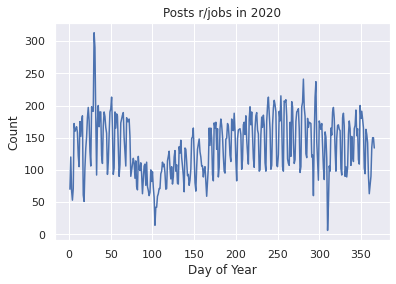

In [12]:
df["dayofyear"].value_counts().loc[list(range(1,367))].plot(kind="line")
plt.title("Posts r/jobs in 2020")
plt.ylabel("Count")
plt.xlabel("Day of Year")
plt.show()

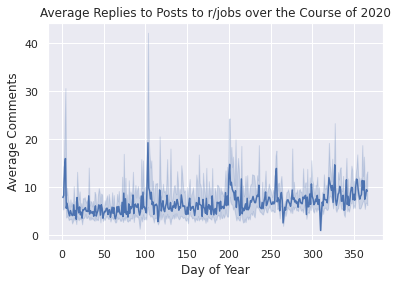

In [13]:
sns.lineplot(x="dayofyear", y="num_comments", data=df, ci=95)
plt.title("Average Replies to Posts to r/jobs over the Course of 2020")
plt.xlabel("Day of Year")
plt.ylabel("Average Comments")
plt.show()

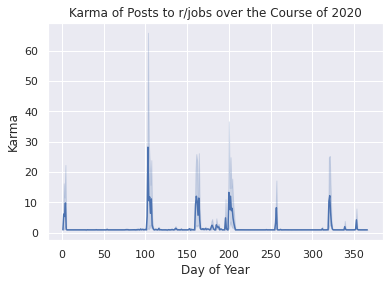

In [14]:
sns.lineplot(x="dayofyear", y="score", data=df, ci=95)
plt.title("Karma of Posts to r/jobs over the Course of 2020")
plt.xlabel("Day of Year")
plt.ylabel("Karma")
plt.show()

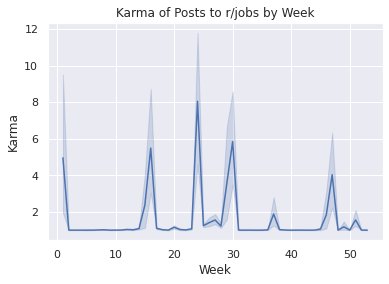

In [15]:
sns.lineplot(x="week", y="score", data=df, ci=95)
plt.title("Karma of Posts to r/jobs by Week")
plt.xlabel("Week")
plt.ylabel("Karma")
plt.show()

We see quite a bit variation with respect to time in these graphs. Based on these data, it looks like users most frequently post to r/jobs early in the week but take a break on the weekend, yet the average number of replies is higher on the weekend (perhaps due to the lack of new posts). Most posts are made in the afternoon of evening, peaking around 7 PM. The posts that earn the most karma and get the most replies are made around noon. There are days over the course of 2020 when there is a lot more activity. That could be an issue with the dataset, or there could be something sociologically interesting about those days.

Let's take a quick look at the distribution of scores and then dive into sentiment.

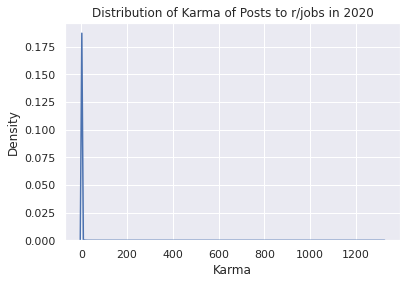

In [16]:
sns.kdeplot("score", data = df)
plt.title("Distribution of Karma of Posts to r/jobs in 2020")
plt.xlabel("Karma")
plt.show()

This distribution highly skewed. Let's take a look at an outlier. We'll look for the post with the highest score.

In [17]:
print(df[df["score"]==df["score"].max()]["text"].values[0])

I was contacted by a recruiter. Gave a low ball salary at $80k. I declined just because it was going to be a 1 hour+ commute, which is longer than my current 1 hour commute. Then he comes back with the real salary range is $100k-$120k. Don't do this if you're a recruiter.
 I really did decline because of the commute. The low salary for the level of work, responsibility, and liability was not an $80k job. Even $120k is the low side. The job is in an economically depressed area and given the current job market, I'm sure they think they'll find someone desperate to fill it. 

I also know the job has been open for at least three weeks. I'm guessing that's why they reached out to me widening their search radius.

I know business is business. But wtf? Trying to undercut someone's salary by 33%? That's just crooked robbery. Be careful right now. Know your worth. Know your industry. Know the job market. There's scavengers out there.

Edit: lots of people asking - I'm an environmental scientist

Let's zoom in and see what the distribution looks like without some of the posts in the long right tail.

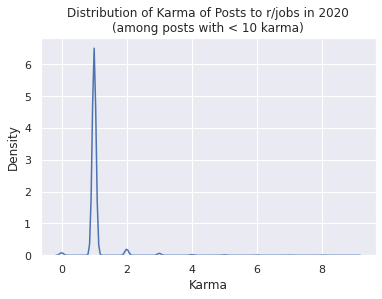

In [18]:
sns.kdeplot("score", data = df[df["score"] < 10])
plt.title("Distribution of Karma of Posts to r/jobs in 2020"
         "\n(among posts with < 10 karma)")
plt.xlabel("Karma")
plt.show()

It seems like the data are clustered pretty tightly around 1 karma, which is where a post starts. Let's see how many posts have something other than 1 karma and look at the distribution of replies.

In [19]:
df[df["score"]!=1].shape

(3032, 212)

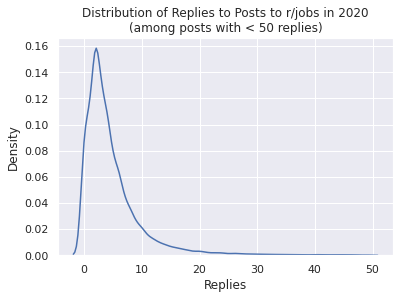

In [20]:
sns.kdeplot("num_comments", data = df[df["num_comments"] < 50])
plt.title("Distribution of Replies to Posts to r/jobs in 2020"
         "\n(among posts with < 50 replies)")
plt.xlabel("Replies")
plt.show()

We also know that people write posts of different lengths. The length of a post could be related to the score, to the topics someone discusses, or other factors.

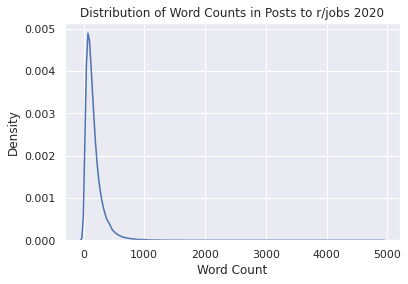

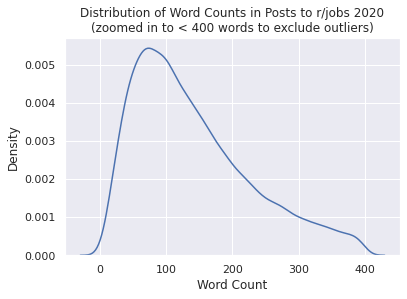

In [21]:
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

sns.kdeplot(df["word_count"])
plt.title("Distribution of Word Counts in Posts to r/jobs 2020")
plt.xlabel("Word Count")
plt.show()

sns.kdeplot(df[df.word_count < 400]["word_count"])
plt.title("Distribution of Word Counts in Posts to r/jobs 2020"
         "\n(zoomed in to < 400 words to exclude outliers)")
plt.xlabel("Word Count")
plt.show()

In [22]:
df[["score", "num_comments", "word_count"]].describe()

,score,num_comments,word_count
count,49872.000000,49872.000000,49872.000000
mean,1.474515,6.581990,170.777530
std,12.838286,18.050039,156.728332
min,0.000000,0.000000,1.000000
25%,1.000000,2.000000,75.000000
50%,1.000000,3.000000,129.000000
75%,1.000000,6.000000,215.000000
max,1322.000000,673.000000,4903.000000


In [23]:
df[["score", "num_comments", "word_count"]].rcorr()

,score,num_comments,word_count
score,-,***,*
num_comments,0.32,-,***
word_count,0.01,0.025,-


In [24]:
print(df[df["word_count"]<75].sample(1)["text"].values[0])

I'm 16 and just finished compulsory education in Denmark. I saw some internships for, e.g SoMe manager- but it isn't clear if I can apply or not. Is there any chance?
 For more information, I have gone to film school after school and know adobe's creative suite and twitter/facebook pretty well and I am doing a-levels in business/econ with distance learning.


In [25]:
print(df[df["word_count"]>215].sample(1)["text"].values[0])

So sick of job applications and feeling really down on myself
 I’ve been unemployed for almost a year now, and it feels so frustrating to continuously apply for jobs, interview and work SO hard to have nothing concrete come of it. I’m just so tired of looking at job descriptions, networking with random people from my college, and going through interviews I know probably won’t amount to anything. What can I do to get any kind of job?! I’ve been applying to things I’m super overqualified for, or at smaller companies/lower paying where they would be happy to have someone like me, coming in with a lot of experience in various sectors and doing really well on my interviews. 

WHY does rejection just keep happening over and over again? How can I find a job that’s easy to get? I’m just so frustrated having to constantly apply to things and feel burned out when I haven’t even technically done anything to advance my career in a year (besides get rejected from hundreds of jobs). WHY IS THIS HAPP

## Using the `Empath` library

Now let's move on to analyzing posts using dictionary methods via the `Empath` library. We'll create the object `lexicon` that will analyze posts using 194 separate dictionaries, which range from positive or negative emotion to topics as diverse as optimism, terrorism, fashion, and eating.

In [26]:
lexicon = Empath()

In [27]:
# Number of categories
len(lexicon.cats.keys())

195

<h1>Lexical categories Provided by <tt>Empath</tt></h1>
<table class='table table-striped'> <tr><th>achievement</th><th>affection</th><th>aggression</th><th>air_travel</th></tr> <tr><th>alcohol</th><th>ancient</th><th>anger</th><th>animal</th></tr> <tr><th>anonymity</th><th>anticipation</th><th>appearance</th><th>art</th></tr> <tr><th>attractive</th><th>banking</th><th>beach</th><th>beauty</th></tr> <tr><th>blue_collar_job</th><th>body</th><th>breaking</th><th>business</th></tr> <tr><th>car</th><th>celebration</th><th>cheerfulness</th><th>childish</th></tr> <tr><th>children</th><th>cleaning</th><th>clothing</th><th>cold</th></tr> <tr><th>college</th><th>communication</th><th>competing</th><th>computer</th></tr> <tr><th>confusion</th><th>contentment</th><th>cooking</th><th>crime</th></tr> <tr><th>dance</th><th>death</th><th>deception</th><th>disappointment</th></tr> <tr><th>disgust</th><th>dispute</th><th>divine</th><th>domestic_work</th></tr> <tr><th>dominant_heirarchical</th><th>dominant_personality</th><th>driving</th><th>eating</th></tr> <tr><th>economics</th><th>emotional</th><th>envy</th><th>exasperation</th></tr> <tr><th>exercise</th><th>exotic</th><th>fabric</th><th>family</th></tr> <tr><th>farming</th><th>fashion</th><th>fear</th><th>feminine</th></tr> <tr><th>fight</th><th>fire</th><th>friends</th><th>fun</th></tr> <tr><th>furniture</th><th>gain</th><th>giving</th><th>government</th></tr> <tr><th>hate</th><th>healing</th><th>health</th><th>hearing</th></tr> <tr><th>help</th><th>heroic</th><th>hiking</th><th>hipster</th></tr> <tr><th>home</th><th>horror</th><th>hygiene</th><th>independence</th></tr> <tr><th>injury</th><th>internet</th><th>irritability</th><th>journalism</th></tr> <tr><th>joy</th><th>kill</th><th>law</th><th>leader</th></tr> <tr><th>legend</th><th>leisure</th><th>liquid</th><th>listen</th></tr> <tr><th>love</th><th>lust</th><th>magic</th><th>masculine</th></tr> <tr><th>medical_emergency</th><th>medieval</th><th>meeting</th><th>messaging</th></tr> <tr><th>military</th><th>money</th><th>monster</th><th>morning</th></tr> <tr><th>movement</th><th>music</th><th>musical</th><th>negative_emotion</th></tr> <tr><th>neglect</th><th>negotiate</th><th>nervousness</th><th>night</th></tr> <tr><th>noise</th><th>occupation</th><th>ocean</th><th>office</th></tr> <tr><th>optimism</th><th>order</th><th>pain</th><th>party</th></tr> <tr><th>payment</th><th>pet</th><th>philosophy</th><th>phone</th></tr> <tr><th>plant</th><th>play</th><th>politeness</th><th>politics</th></tr> <tr><th>poor</th><th>positive_emotion</th><th>power</th><th>pride</th></tr> <tr><th>prison</th><th>programming</th><th>rage</th><th>reading</th></tr> <tr><th>real_estate</th><th>religion</th><th>restaurant</th><th>ridicule</th></tr> <tr><th>royalty</th><th>rural</th><th>sadness</th><th>sailing</th></tr> <tr><th>school</th><th>science</th><th>sexual</th><th>shame</th></tr> <tr><th>shape_and_size</th><th>ship</th><th>shopping</th><th>sleep</th></tr> <tr><th>smell</th><th>social_media</th><th>sound</th><th>speaking</th></tr> <tr><th>sports</th><th>stealing</th><th>strength</th><th>suffering</th></tr> <tr><th>superhero</th><th>surprise</th><th>swearing_terms</th><th>swimming</th></tr> <tr><th>sympathy</th><th>technology</th><th>terrorism</th><th>timidity</th></tr> <tr><th>tool</th><th>torment</th><th>tourism</th><th>toy</th></tr> <tr><th>traveling</th><th>trust</th><th>ugliness</th><th>urban</th></tr> <tr><th>vacation</th><th>valuable</th><th>vehicle</th><th>violence</th></tr> <tr><th>war</th><th>warmth</th><th>water</th><th>weakness</th></tr> <tr><th>wealthy</th><th>weapon</th><th>weather</th><th>wedding</th></tr> <tr><th>white_collar_job</th><th>work</th><th>worship</th><th>writing</th></tr> </table>

In [28]:
df["text"] = df["text"].apply(str.lower) # lowercasing the text

In [29]:
example = df.sample(1)
example_text = example["text"].values[0]
print(example_text)

how long in the construction industry will it take me to become a heavy equipment operator?
 starting out as a labourer i suppose?


In [30]:
lexicon.analyze(example_text)

{'help': 0.0,
 'office': 0.0,
 'dance': 0.0,
 'money': 0.0,
 'wedding': 0.0,
 'domestic_work': 0.0,
 'sleep': 0.0,
 'medical_emergency': 0.0,
 'cold': 0.0,
 'hate': 0.0,
 'cheerfulness': 0.0,
 'aggression': 0.0,
 'occupation': 0.0,
 'envy': 0.0,
 'anticipation': 0.0,
 'family': 0.0,
 'vacation': 0.0,
 'crime': 0.0,
 'attractive': 0.0,
 'masculine': 0.0,
 'prison': 0.0,
 'health': 0.0,
 'pride': 0.0,
 'dispute': 0.0,
 'nervousness': 0.0,
 'government': 0.0,
 'weakness': 0.0,
 'horror': 0.0,
 'swearing_terms': 0.0,
 'leisure': 0.0,
 'suffering': 0.0,
 'royalty': 0.0,
 'wealthy': 0.0,
 'tourism': 0.0,
 'furniture': 0.0,
 'school': 0.0,
 'magic': 0.0,
 'beach': 0.0,
 'journalism': 0.0,
 'morning': 0.0,
 'banking': 1.0,
 'social_media': 0.0,
 'exercise': 0.0,
 'night': 0.0,
 'kill': 0.0,
 'blue_collar_job': 0.0,
 'art': 0.0,
 'ridicule': 0.0,
 'play': 0.0,
 'computer': 0.0,
 'college': 0.0,
 'optimism': 0.0,
 'stealing': 0.0,
 'real_estate': 0.0,
 'home': 0.0,
 'divine': 0.0,
 'sexual': 0.0

The output is a dictionary: each lexical category is a key and the score is the value. Let's define a function to print the output in a more manageable way. The function below finds all lexical categories where the score is nonzero for a given post, sorts them, and then print at most <texttt>max_results</texttt> results. 

In [31]:
def analyze_post(post: str, normalize:bool=True, max_results=10):
    """
    Prints dictionaries and scores for nonzero scores
    """
    analysis = lexicon.analyze(post, normalize=normalize)
    nonzero = []
    for key, value in analysis.items():
        if value > 0.0:
            nonzero.append((key, value))
    nonzero = sorted(nonzero, key=lambda x: x[1], reverse=True)
    nonzero = nonzero[:min(max_results, len(nonzero))]
    for lex in nonzero:
        print(f"{lex[1]:.2f} {lex[0]}")

**Normalizing** is an important choice when using these methods. Compare the results below. Whether normalizing ultimately matters may depend on what we're trying to accomplish. For now, let's stick to normalizing. Posts vary a lot in length.

In [32]:
analyze_post(example_text, normalize=False)

3.00 work
1.00 banking
1.00 business
1.00 tool
1.00 gain
1.00 economics


In [33]:
analyze_post(example_text, normalize=True)

0.13 work
0.04 banking
0.04 business
0.04 tool
0.04 gain
0.04 economics


**Preprocessing** is also an important step for a lot of tasks. The code below loads a language model from `spacy`, disables some of its functionality (Named Entity Recognition) to make it run faster, and then preprocesses the sentence using the model. `nlp(example_text)` analyzes the string using the language model we have loaded, and it does things like part-of-speech tagging. We can also remove stopwords and [lemmatize](https://en.wikipedia.org/wiki/Lemmatisation).

In [34]:
# python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=["ner"])

In [35]:
prep_example_text = nlp(example_text)
prep_example_text = [word.lemma_ for word in prep_example_text if not word.is_stop]
print(prep_example_text)

['long', 'construction', 'industry', 'heavy', 'equipment', 'operator', '?', '\n ', 'start', 'labourer', 'suppose', '?']


In [36]:
analyze_post(prep_example_text, normalize=True)

0.27 work
0.09 banking
0.09 business
0.09 tool
0.09 phone
0.09 gain
0.09 economics


In [37]:
lexicon.analyze(prep_example_text, normalize=True)["negative_emotion"]

0.0

The dataset has a variable ("preprocessed") with preprocessed versions of the posts and variables for each of the dictionaries provided by `Empath`.

### Most and least positive and negative posts

Let's take a look at the most positive post according to the positive_sentiment lexicon:

In [38]:
most_pos = df[df.positive_emotion==df.positive_emotion.max()]

display(most_pos[["score", "num_comments", "date"]])

print(most_pos["title"].values[0])
print(most_pos["selftext"].values[0])

,score,num_comments,date
47089,1,22,2020-08-14


I love my job
Hey I love my job


And the most negative post:

In [39]:
most_pos = df[df.negative_emotion==df.negative_emotion.max()]

display(most_pos[["score", "num_comments", "date"]])

print(most_pos["title"].values[0])
print(most_pos["selftext"].values[0])

,score,num_comments,date
60111,1,11,2020-10-25


What’s wrong
Why is it very hard get a job for me ?


What about the *least positive* or *least negative*? Unfortunately, these are going to be 0.0 and apply to a large portion of posts. Even if we standardize these, the lowest values will still be the posts that don't use relevant words, not necessarily words meaning the *opposite*. In fact, we'll often see that posts that use words related to one category use words related to the opposite. Positive and negative sentiment words are actually highly correlated according to this dictionary-based approach.

In [40]:
print(f"Minimum for positive and negative emotion: {df.positive_emotion.min()} and {df.negative_emotion.min()}")

Minimum for positive and negative emotion: 0.0 and 0.0


In [41]:
print(f"Correlation between positive and negative emotion: r = {quick_r('negative_emotion', 'positive_emotion', df)}")

Correlation between positive and negative emotion: r = 0.16***


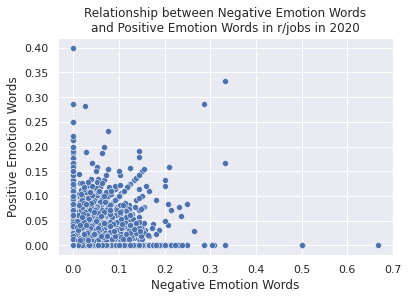

In [42]:
sns.scatterplot(x="negative_emotion", y="positive_emotion", data=df)
plt.xlabel("Negative Emotion Words")
plt.ylabel("Positive Emotion Words")
plt.title("Relationship between Negative Emotion Words\nand Positive Emotion Words in r/jobs in 2020")
plt.show()

### Temporal Trends in Sentiment

Do posts tend to relate to positive or negative sentiment to different degrees at different points in time? We'll plot these to find out and even check some of the correlations. Importantly, days and weeks are cyclical, so establishing a linear trend (as with a correlation coefficient) is unlikely. We might also expect seasonal effects over the course of the year if people are shorter on money at different times, if having money seems more important at different times (e.g., around specific holidays), or if people tend to lose their jobs more at certain times of year.

*On the other hand*, we're looking at 2020. There may be shifts in how much emotion words are used, on average, as the pandemic worsens. As a consequence, we may see linear trends over the course of the year.

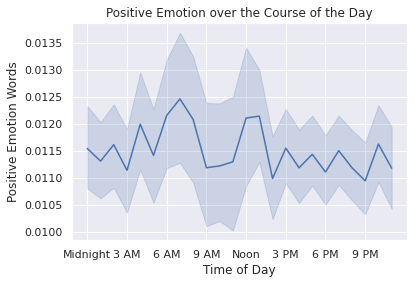

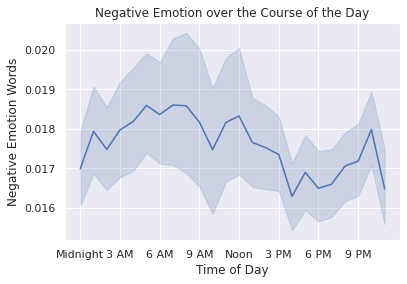

In [43]:
sns.lineplot(x="hour", y="positive_emotion", data=df)
plt.title("Positive Emotion over the Course of the Day")
plt.ylabel("Positive Emotion Words")
plt.xlabel("Time of Day")
plt.xticks(ticks=range(0,24,3), labels=hours[::3])
plt.show()

sns.lineplot(x="hour", y="negative_emotion", data=df)
plt.title("Negative Emotion over the Course of the Day")
plt.ylabel("Negative Emotion Words")
plt.xlabel("Time of Day")
plt.xticks(ticks=range(0,24,3), labels=hours[::3])
plt.show()

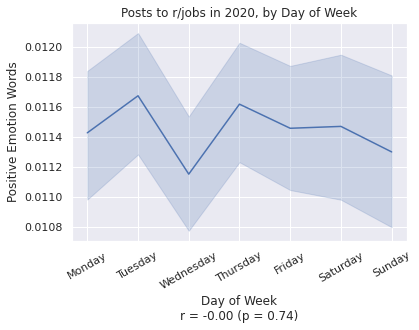

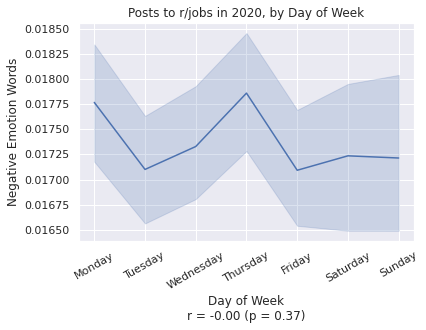

In [44]:
plt.title("Posts to r/jobs in 2020, by Day of Week")
sns.lineplot(x="dayofweek", y="positive_emotion", data=df, ci=95) # sem
plt.ylabel("Positive Emotion Words")
plt.xticks(ticks=range(0,7), labels=daysofweek, rotation=30)
plt.xlabel(f"Day of Week\nr = {quick_r('dayofweek', 'positive_emotion', df)}")
plt.show()

plt.title("Posts to r/jobs in 2020, by Day of Week")
sns.lineplot(x="dayofweek", y="negative_emotion", data=df, ci=95) # sem
plt.ylabel("Negative Emotion Words")
plt.xticks(ticks=range(0,7), labels=daysofweek, rotation=30)
plt.xlabel(f"Day of Week\nr = {quick_r('dayofweek', 'negative_emotion', df)}")
plt.show()

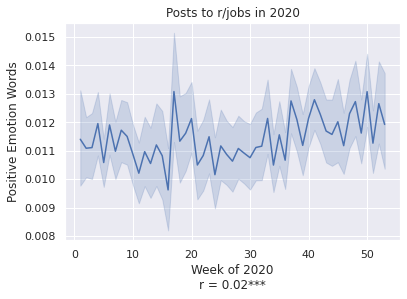

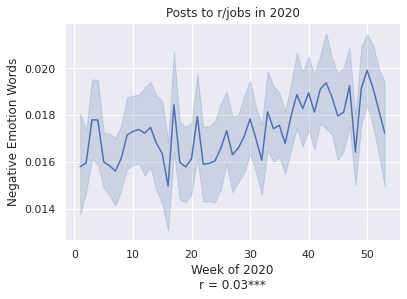

In [45]:
plt.title("Posts to r/jobs in 2020")
sns.lineplot(x="week", y="positive_emotion", data=df, ci=95) # sem
plt.ylabel("Positive Emotion Words")
plt.xlabel(f"Week of 2020\nr = {quick_r('week', 'positive_emotion', df)}")
plt.show()

plt.title("Posts to r/jobs in 2020")
sns.lineplot(x="week", y="negative_emotion", data=df, ci=95) # sem
plt.ylabel("Negative Emotion Words")
plt.xlabel(f"Week of 2020\nr = {quick_r('week', 'negative_emotion', df)}")
plt.show()

### Standardizing Variables

Before we dive into the rest of our analyses, we are going to "standardize" the variables. If you have some background in statistics, this may be familiar: we subtract the mean of a variable from each value and divide by the standard deviation, which is the same as calculating a [z-score](https://en.wikipedia.org/wiki/Z-score). This sets the mean of the variable to zero and the standard deviation to one.

Standardizing variables offers two major advantages that are relevant to this class. First, sometimes variables are just difficult to interpret. Have you ever been asked whether you agree or disagree with a statement on a scale of 1-7 (or 1-5, or 0-100)? What would it mean to say that the difference between two groups is 0.24 on that 1-7 scale? Often, psychologists and others standardize variables so that differences have a more straightforward interpretation. This interpretation is that a difference is some fraction of a standard deviation. When analyzing the results of an experiment, a psychologist might say that the treatment has an effect on the outcome of 0.4 standard deviations. That's pretty opaque--but many people find it more intuitive than saying the effect is 0.24 out of seven.

The second and most immediately obvious advantage is that we can plot standardized variables at the same time. Examine the two plots below. The first plot includes unstandardized variables. If we were to look at any one of these variables, we may see more ups and downs, but the additional variables change the scale of the y-axis. This means we have zoomed out and the ups and downs are more difficult to see. (Whether the ups and downs matter is another question, and we'll talk more about this!)

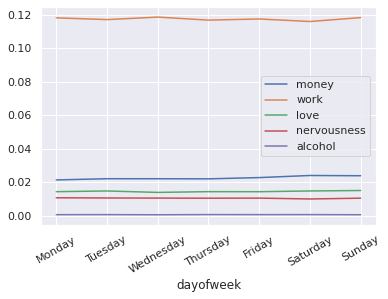

In [46]:
daysofweek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df[["dayofweek", "money", "work", "love", "nervousness", "alcohol"]].groupby("dayofweek").mean(["money", "work", "love", "nervousness", "alcohol"]).plot(kind="line")
plt.xticks(ticks=range(0,7), labels=daysofweek, rotation=30)
plt.show()

In [47]:
df[["money", "work", "love", "nervousness", "alcohol"]].describe()

,money,work,love,nervousness,alcohol
count,49868.000000,49868.000000,49868.000000,49868.000000,49868.000000
mean,0.022351,0.117543,0.014366,0.010392,0.000522
std,0.034592,0.065404,0.022281,0.019507,0.004473
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.074074,0.000000,0.000000,0.000000
50%,0.008333,0.110000,0.000000,0.000000,0.000000
75%,0.033333,0.151515,0.022727,0.015625,0.000000
max,0.500000,1.000000,0.400000,0.400000,0.200000


In [48]:
def standardize(series):
    """
    Mean-centers a variable and divides by the standard deviation,
    resulting in a mean of zero and a standard deviation of one.
    This puts variables on the same scale and can make comparisons
    a bit easier to see.
    """
    if max(series) == 0.0:
        return series
    mu = np.mean(series.dropna())
    assert type(mu) == np.float64
    std = np.std(series.dropna(), ddof=1) + 1e-7
    assert type(std) == np.float64
    series = [(val-mu)/std for val in series.values]
    return series

In [49]:
start_time = time.time()

for cat in lexicon.cats.keys():
    if cat != "stigma":
        df[cat] = standardize(df[cat])
    
print(time.time()-start_time)

2.950413703918457


In [50]:
df[["money", "work", "love", "nervousness", "alcohol"]].describe()

,money,work,love,nervousness,alcohol
count,4.986800e+04,4.986800e+04,4.986800e+04,4.986800e+04,4.986800e+04
mean,-4.395653e-17,-5.257686e-17,-1.043344e-16,-7.964895e-17,2.657340e-17
std,9.999971e-01,9.999985e-01,9.999955e-01,9.999949e-01,9.999776e-01
min,-6.461376e-01,-1.797177e+00,-6.447591e-01,-5.327403e-01,-1.167443e-01
25%,-6.461376e-01,-6.646233e-01,-6.447591e-01,-5.327403e-01,-1.167443e-01
50%,-4.052366e-01,-1.153349e-01,-6.447591e-01,-5.327403e-01,-1.167443e-01
75%,3.174663e-01,5.194098e-01,3.752638e-01,2.682561e-01,-1.167443e-01
max,1.380792e+01,1.349229e+01,1.730764e+01,1.997277e+01,4.459379e+01


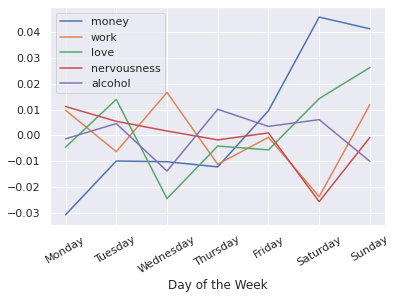

In [51]:
daysofweek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df[["dayofweek", "money", "work", "love", "nervousness", "alcohol"]].groupby("dayofweek").mean(["money", "work", "love", "nervousness", "alcohol"]).plot(kind="line")
plt.xticks(ticks=range(0,7), labels=daysofweek, rotation=30)
plt.xlabel("Day of the Week")
plt.show()

This plot is a mess, but we see a lot of change from day to day!

### Do people talk about different things at different times?

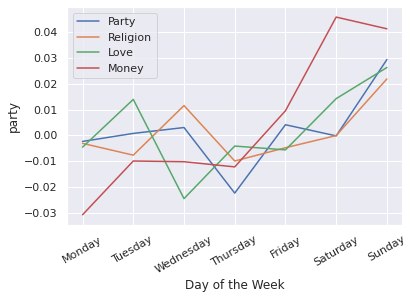

In [52]:
daysofweek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

vars_to_plot = ["party", "religion", "love", "money"]

plot_ci=None

for var in vars_to_plot:
    sns.lineplot(x="dayofweek", y=var, data=df, ci=plot_ci)
plt.xticks(ticks=range(0,7), labels=daysofweek, rotation=30)
plt.xlabel("Day of the Week")
plt.legend(labels=[v.capitalize() for v in vars_to_plot])
plt.show()

In [53]:
df[["party", "religion", "love", "money"]].rcorr()

,party,religion,love,money
party,-,,***,***
religion,0.007,-,,
love,-0.038,0.003,-,***
money,-0.026,-0.002,-0.025,-


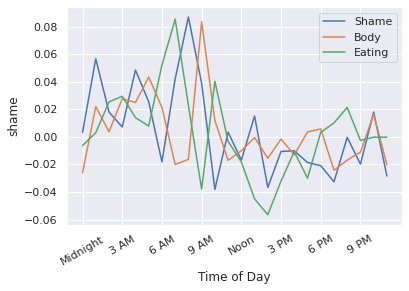

In [54]:
vars_to_plot = ["shame", "body", "eating"]

plot_ci=None

for var in vars_to_plot:
    sns.lineplot(x="hour", y=var, data=df, ci=plot_ci)
plt.xticks(ticks=range(0,24,3), labels=hours[::3], rotation=30)
plt.xlabel("Time of Day")
plt.legend(labels=[v.capitalize() for v in vars_to_plot])
plt.show()

In [55]:
df[["shame", "body", "eating"]].rcorr()

,shame,body,eating
shame,-,***,
body,0.596,-,***
eating,0.002,0.016,-


## Exercises

First, pick a social problem you would like to explore using this corpus. In Exercise 1, you will create a dictionary for that topic in only three lines of code. You will use your dictionary for the remaining exercises.

`Empath` makes creating dictionaries for different lexical categories fairly straightforward on the surface. Beneath the surface, it uses some pretty powerful tools. We'll learn about these tools (such as word embeddings) later in the class. For now, all we need to know is that we can provide a small list of words related to our chosen topic and `Empath` will give us a longer list of related words. We can use that list as our lexicon.

For example, let's say we want to create a lexicon related to stigma. We can seed (start) our lexicon using a handful of words. Let's try these:

In [56]:
stigma_words = ["stigma", "taboo", "avoid", "aversion", "stereotype", "trash"]

Now we can create our lexicon using the following line of code. The first part (<tt>"stigma"</tt>) is what we are naming the category. The second part (<tt>stigma_words</tt>) is the list we created in the line above). The <tt>model="reddit"</tt> argument means we will find words that are related based on how language is (was) used in Reddit data when `Empath` was created. The alternatives are based on the New York Times and a collection of fiction.

Note: we will talk a LOT more about word embeddings and vector space models in the future, and you will learn how they are used to generate collections of words like the following. The TL;DR is that these tools assume words are "similar" if they are used in similar contexts. This assumption can make it easy to find synonyms, but sometimes tools based on this assumption will think _antonyms_ are highly "similar" in this specific sense. These tools can also reflect social prejudices, which can make them useful for studying those issues (as we will later in the course) but may be a bit of a surprise. **Debiasing** word embeddings and other tools is also an active area of research, and we will discuss that more.

In other words, you may see examples of prejudice inherent to the language used on Reddit (or in fiction or the New York Times), but that doesn't mean that a word that shows up should be seen as part of the reality of your topic.

In [57]:
lexicon.create_category("stigma", stigma_words, model="reddit", size=100)

["stigma", "negative_thing", "social_stigma", "taboo", "negative_stigma", "aversion", "stigmas", "negative_connotations", "weird_idea", "negative_connotation", "stereotype", "negative_association", "positive_thing", "taboo", "stigmatized", "social_pressure", "bad_thing", "stigmatization", "negative_associations", "whole_culture", "negative_attitudes", "fetishization", "stereotypes", "negative_view", "social_taboo", "cultural_norm", "taboo", "huge_stigma", "fetishizing", "stigmatize", "irrational_fear", "ironically", "normal_thing", "certain_people", "stupid_stereotypes", "stigma", "negative_stereotypes", "natural_thing", "obsession", "preconception", "fetishize", "shunning", "negative_things", "serious_problem", "social_norm", "skewed_view", "prudishness", "negative_aspects", "real_problem", "ridiculous_notion", "stereotyping", "demeaning", "double_standard", "real_issue", "negative_stereotype", "gay_culture", "disdain", "social_stigmas", "typical_thing", "negative_perception", "good_t

Also notice the n-grams connected by underscores (for example, "cultural_norm") and compound words (for example, "slut_shaming"). The corpus of posts from r/jobs only has unigrams and has no punctuation. We'll cover those issues more later on in the course. For now, that just means there are words in the lexicon that won't appear in any of the documents in this corpus.

That aside, this custom lexicon can now be used just like those we've already used. The line of code below will add a variable to our dataframe. Be sure to include the <tt>normalize=True</tt> argument when you create your own in Exercise 1! Alternatively, if you'd prefer to use the raw counts, you should use the raw counts for the other lexical categories as well, as we initially did toward the beginning of this notebook. If you opt to use raw counts, please provide your rationale.

In [58]:
def score_category(s, category, normalize=True):
    """
    This function returns the score for a given document for a particular category
    using empath's dictionaries. The optional argument `normalize` defaults to False.
    """
    res = lexicon.analyze(s, categories=[category], normalize=normalize)
    if res:
        return res[category]
    return 0.0


df["stigma"] = [score_category(s, "stigma", normalize=True) for s in df["preprocessed"].values]
df["stigma"] = standardize(df["stigma"])

<div class="alert alert-warning"><strong></strong>
There you have it! We've created our own lexicon for the lexical category "stigma" in only three lines of code using `empath`!

Now you will do the same.

### Exercise 1
1. Create your custom lexicon by modifying the code below.
    
1.1 Replace "LISTOFWORDS" with whatever you like, but create a list of words to seed (start) your lexicon
</div>

In [59]:
LISTOFWORDS = []

<div class="alert alert-warning"><strong></strong>
1.2 Now pick a name for your lexicon (replacing "YOURCATEGORYNAMEHERE") and replace LISTOFWORDS with your list. If you'd prefer, you can use the alternatives to Reddit-based word embeddings discussed above. You can also modify the size argument.
</div>

In [60]:
lexicon.create_category("YOURCATEGORYNAMEHERE", LISTOFWORDS, model="reddit", size=100)

[]


<div class="alert alert-warning"><strong></strong>
1.3 Replace the name with your chosen name and run this cell
</div>

In [61]:
df["YOURCATEGORYNAMEHERE"] = [score_category(s, "YOURCATEGORYNAMEHERE", normalize=True) for s in df["text"].values]
df["YOURCATEGORYNAMEHERE"] = standardize(df["YOURCATEGORYNAMEHERE"])

<div class="alert alert-warning"><strong>Exercise 2</strong>
    
Now you will use your lexicon to conduct a few analyses of your own. First, describe the topic you chose and a few hypotheses.


2.1 What topic did you choose, and what could it tell us about social processes and social institutions?</div>

_Your answer here_

<div class="alert alert-warning">2.2 Is text data useful for studying your topic? (It's okay if you don't think it is!)</div>

_Your answer here_

<div class="alert alert-warning"><strong>Exercise 3</strong>

Now let's think about how your topic might relate to social institutions like work, schooling, or others that might structure time use (that is, what people do at what times).

3.1 Come up with a hypothesis about when during the week redditors may be more or less likely to post about your topic to r/offmychest. If you believe there's no reason to expect a relationship between the day of the week and writing about your topic, you may explain why instead. Clarify whether your hypothesis is causal or correlational (although we will not adequately _test_ causal claims at this point). You may also describe potential confounding variables.</div>

_Your answer here_


<div class="alert alert-warning">3.2 Create a plot showing variation in the frequency of posts about your topic to r/offmychest over the course of the week. You may modify code from earlier in the notebook.</div>

In [62]:
# YOUR CODE HERE

<div class="alert alert-warning">3.3 Does this plot support your hypothesis? If you have a background in statistics or want to try something new, you may conduct and refer to formal hypothesis tests. If you believe there may be confounding variables, please describe them.</div>

_Your answer here_

<div class="alert alert-warning"><strong>Exercise 4</strong>

4.1 Come up with a hypothesis about when during the _day_ redditors may be more or less likely to post about your topic to r/offmychest. If you believe there's no reason to expect a relationship between time of day and writing about your topic, you may explain why instead. Clarify whether your hypothesis is causal or correlational (although we will not adequately _test_ causal claims at this point). You may also describe potential confounding variables.</div>

_Your answer here_


<div class="alert alert-warning">4.2 Create a plot showing variation in the frequency of posts about your topic to r/offmychest over the course of the day. You may modify code from earlier in the notebook.</div>

In [63]:
# YOUR CODE HERE

<div class="alert alert-warning">4.3 Does this plot support your hypothesis? If you have a background in statistics or want to try something new, you may conduct and refer to formal hypothesis tests. If you believe there may be confounding variables, please describe them.</div>

_Your answer here_

<div class="alert alert-warning"><strong>Exercise 5</strong>

5.1 Come up with a hypothesis about whether a post's karma (upvotes, the "score" field in our dataset) would be related to the extent your topic is discussed. If you believe there is no reason to expect such a relationship, you may explain that instead. Clarify whether your hypothesis is causal or correlational (although we will not adequately _test_ causal claims at this point). You may also describe potential confounding variables.</div>

_Your answer here_

<div class="alert alert-warning">5.2 Create a plot showing the relationship between a post's score (df["score"]) and your topic. You may modify code from earlier in the notebook.</div>

In [64]:
# YOUR CODE HERE

<div class="alert alert-warning">5.3 Does this plot support your hypothesis? If you have a background in statistics or want to try something new, you may conduct and refer to formal hypothesis tests. If you believe there may be confounding variables, please describe them.</div>

_Your answer here_

<div class="alert alert-warning"><strong>Exercise 6</strong>

6.1 Come up with a hypothesis about another lexical category that should be associated (positively or negatively) with your own category. Be sure to think about social practices. What is it about how people live that makes it likely they would (or would not) write about both your topic and this other topic in the same posts to r/offmychest? Clarify whether your hypothesis is causal or correlational (although we will not adequately _test_ causal claims at this point). You may also describe potential confounding variables.</div>

_Your answer here_

<div class="alert alert-warning">6.2 Create a plot showing the relationship between your category and the category you chose. You may modify code from earlier in the notebook.</div>

In [65]:
# YOUR CODE HERE

<div class="alert alert-warning">6.3 Does this plot support your hypothesis? If you have a background in statistics or want to try something new, you may conduct and refer to formal hypothesis tests. If you believe there may be confounding variables, please describe them.</div>

_Your answer here_